# Conversion Rate
__- Author: Fan Yuan__  
__- Date: 03/21/2019__

## Project goal:
* Build a model that predicts conversion rate
* Come up with recommendation for the product team and the marketing team to improve conversion rate  

## Columns:
* __country__: user country based on the IP address
* __age__: user age. Self-reported at sign-in steo
* __new_user__: whether the user created the account during this session or had already an account and simply came back to the site
* __source__: marketing channel source
    + Ads: came to the site by clicking on an advertisement
    + Soe: came to the site by clicking on search results
    + Direct: came to the site by directly typing the URL on the browser
* __total_pages_visited__: number of total pages visited during the session. This is a proxy for time spent on site and engagement during the session
* __converted__: this is our label. 1 means they converted within the session, 0 means they left without buying anything. The company's goal is to increase conversion rate: # conversions / total sessions

___The table has information about signed-in users during one session. Each row is a user session.___

In [18]:
# libraries needed
library(tidyverse)
library(randomForest)
library(rpart)

# reset the sieze of graph
options(repr.plot.width=4, repr.plot.height=3)

In [1]:
# read in the data
data <- read.csv('./Data/conversion_data.csv')

# explore the first several rows of data
head(data)

country,age,new_user,source,total_pages_visited,converted
UK,25,1,Ads,1,0
US,23,1,Seo,5,0
US,28,1,Seo,4,0
China,39,1,Seo,5,0
US,30,1,Seo,6,0
US,31,0,Seo,1,0


In [3]:
# check the structure of the data
str(data)

'data.frame':	316200 obs. of  6 variables:
 $ country            : Factor w/ 4 levels "China","Germany",..: 3 4 4 1 4 4 1 4 3 4 ...
 $ age                : int  25 23 28 39 30 31 27 23 29 25 ...
 $ new_user           : int  1 1 1 1 1 0 1 0 0 0 ...
 $ source             : Factor w/ 3 levels "Ads","Direct",..: 1 3 3 3 3 3 3 1 2 1 ...
 $ total_pages_visited: int  1 5 4 5 6 1 4 4 4 2 ...
 $ converted          : int  0 0 0 0 0 0 0 0 0 0 ...


In [4]:
# inspect the data to look if there's unnormal data and clean it if necessary
summary(data)

    country            age            new_user         source      
 China  : 76602   Min.   : 17.00   Min.   :0.0000   Ads   : 88740  
 Germany: 13056   1st Qu.: 24.00   1st Qu.:0.0000   Direct: 72420  
 UK     : 48450   Median : 30.00   Median :1.0000   Seo   :155040  
 US     :178092   Mean   : 30.57   Mean   :0.6855                  
                  3rd Qu.: 36.00   3rd Qu.:1.0000                  
                  Max.   :123.00   Max.   :1.0000                  
 total_pages_visited   converted      
 Min.   : 1.000      Min.   :0.00000  
 1st Qu.: 2.000      1st Qu.:0.00000  
 Median : 4.000      Median :0.00000  
 Mean   : 4.873      Mean   :0.03226  
 3rd Qu.: 7.000      3rd Qu.:0.00000  
 Max.   :29.000      Max.   :1.00000  

__From the data summary, we can see__
- The majory of users is from US and China is in the second
- User distribution is young
- The average conversion rate is around 3%
- Maximum of age columns seems not make sense

In [5]:
# inspect how many users who have unrealistc age
subset(data, age > 100)

,country,age,new_user,source,total_pages_visited,converted
90929,Germany,123,0,Seo,15,1
295582,UK,111,0,Ads,10,1


* It shows that only 2 users have unormal age, we can just remove them.

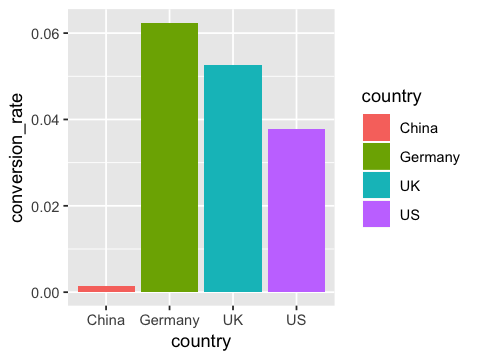

In [6]:
# remove the unreasonable data
data <- subset(data, age < 100)

# explore the data to see if there's any difference pattern between two classes
# group the data by country to get the sense of conversion distribution
data_country <- data %>%
                group_by(country) %>%
                summarise(conversion_rate = mean(converted))

# plot the graph
ggplot(data = data_country, aes(x = country, y = conversion_rate)) +
    geom_bar(stat = "identity", aes(fill = country))

* As shown above, Chinese convert at a much lower rate than other countries

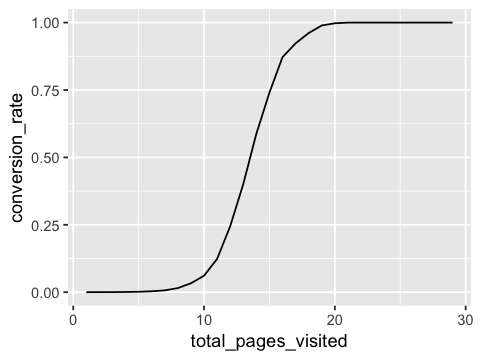

In [7]:
# negivate the relation between pages visited and conversion rate
data_pages <- data %>%
                group_by(total_pages_visited) %>%
                summarise(conversion_rate = mean(converted))

# plot the graph
ggplot(data = data_pages, aes(x = total_pages_visited, y = conversion_rate)) +
    geom_line()

* As shown above, spending more time will probably result in higher probability of conversion

In [8]:
# Build the model to predict conversion rate
# Model: Random Forest
# Reason: Random Forest takes less time to optimize and it handles outliers irrelevant variables well

# Do some basis data cleaning
# Make 'Converted', 'new_user' into factor
data$converted <- as.factor(data$converted)
data$new_user <- as.factor(data$new_user)

# Shorter the name for clearer plot
levels(data$country)[levels(data$country)=='Germany'] <- "DE"
levels(data$country)[levels(data$country)=='China'] <- "CN"
# levels(data$country)

In [9]:
# Split train & test data
train_sample <- sample(nrow(data),size = nrow(data) * 0.66)
train_data <- data[train_sample,]
test_data <- data[-train_sample,]

# Build the forest with standard values for the 3 most important parameters 
# (100 trees, 3 random variables selected at each split)
rf <- randomForest(y = train_data$converted, x = train_data[, -ncol(train_data)],
                   ytest = test_data$converted, xtest = test_data[, -ncol(test_data)], 
                   ntree = 100, mtry = 3, keep.forest = TRUE)
rf


Call:
 randomForest(x = train_data[, -ncol(train_data)], y = train_data$converted,      xtest = test_data[, -ncol(test_data)], ytest = test_data$converted,      ntree = 100, mtry = 3, keep.forest = TRUE) 
               Type of random forest: classification
                     Number of trees: 100
No. of variables tried at each split: 3

        OOB estimate of  error rate: 1.43%
Confusion matrix:
       0    1 class.error
0 201023  903 0.004471935
1   2089 4675 0.308840923
                Test set error rate: 1.46%
Confusion matrix:
       0    1 class.error
0 103593  481 0.004621711
1   1090 2344 0.317414094

* OOB error and test error are similar with 1.5% and 1.4%. So the model is not overfitting. However, at the beginning, the accuracy is 97% if we classified everything as "non converted". So 98.5% is good but not surprising, and actually 30% of conversions are predicted as "non conversion"

* Here we won't do ROC and cut-off analysis since in this case, it doesn't affect a lot. The fefault 0.5 cutoff value used internally by the random forest is fine

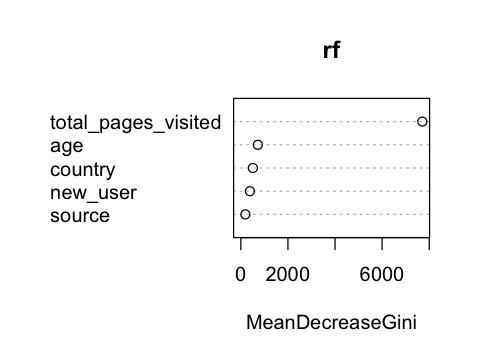

In [10]:
# Check variable importance
varImpPlot(rf, type = 2)

* The graph above shows 'total_pages_visited' is teh most important variable but probably the least "actionable". This is because people visit many pages when they've already want to buy. There, next we will rebuild the Random Forest model without this variable.

* Since classes are heavily unbalanced and we don't have that very powerful variable, we'll change the wight a little to make sure we will get something classified as 1

In [11]:
rf <- randomForest(y = train_data$converted, x = train_data[, -c(5, ncol(train_data))], 
                   ytest = test_data$converted, xtest = test_data[, -c(5, ncol(test_data))], 
                   ntree = 100, mtry = 3, keep.forest = TRUE, classwt = c(0.7, 0.3))
rf


Call:
 randomForest(x = train_data[, -c(5, ncol(train_data))], y = train_data$converted,      xtest = test_data[, -c(5, ncol(test_data))], ytest = test_data$converted,      ntree = 100, mtry = 3, classwt = c(0.7, 0.3), keep.forest = TRUE) 
               Type of random forest: classification
                     Number of trees: 100
No. of variables tried at each split: 3

        OOB estimate of  error rate: 14.36%
Confusion matrix:
       0     1 class.error
0 175045 26881   0.1331230
1   3080  3684   0.4553519
                Test set error rate: 14.46%
Confusion matrix:
      0     1 class.error
0 90050 14024   0.1347503
1  1527  1907   0.4446709

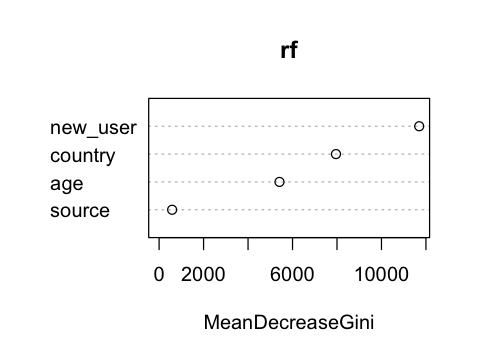

In [12]:
# Recheck the variable importance
varImpPlot(rf, type =2)

* Now the 'new_user' becomes the most important one, and 'Source' doesn't seem to matter at all

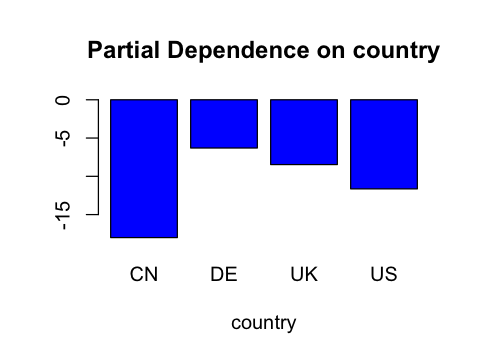

In [14]:
# Check partial dependence plots for the 4 variables
partialPlot(rf, train_data, country, 1)

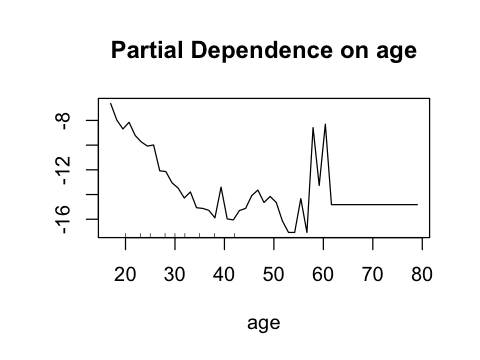

In [15]:
partialPlot(rf, train_data, age, 1)

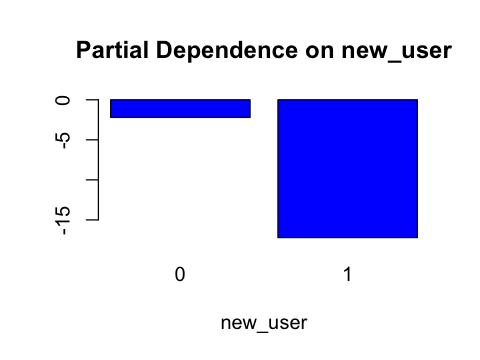

In [16]:
partialPlot(rf, train_data, new_user, 1)

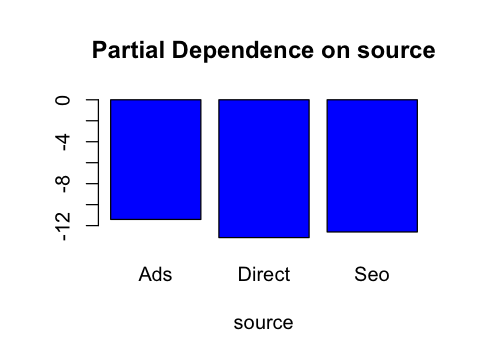

In [17]:
partialPlot(rf, train_data, source, 1)

__In partial dependence plots, it shows:__
+ Users with an old account are better than new users
+ China is doing bad, all other countries are similar with Germany being the best
+ The site works very well for young people and bad for elder people (>30 years old)
+ Source is irrelevant



In [19]:
# Build a simple decision tree and check the 2 or 3 most important segments:
tree <- rpart(data$converted ~., data[, -c(5, ncol(data))], 
              control = rpart.control(maxdepth = 3), parms = list(prior = c(0.7, 0.3)))
tree

n= 316198 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 316198 94859.4000 0 (0.70000000 0.30000000)  
   2) new_user=1 216744 28268.0600 0 (0.84540048 0.15459952) *
   3) new_user=0 99454 66591.3400 0 (0.50063101 0.49936899)  
     6) country=CN 23094   613.9165 0 (0.96445336 0.03554664) *
     7) country=DE,UK,US 76360 50102.8100 1 (0.43162227 0.56837773)  
      14) age>=29.5 38341 19589.5200 0 (0.57227507 0.42772493) *
      15) age< 29.5 38019 23893.0000 1 (0.33996429 0.66003571) *

### Conclusion and suggestions:
1. The site works well for young users. Tell marketing to advertise and use marketing channel which are more likely to reach young people
2. the site works very well for Germany in terms of conversion. But the summary showed that there are few Germans coming to the site: way less than UL, despite a large population. Marketing should get more Germans
3. Users with old accounts do much better. Targeted emails with offers to bring them back to the site could be good idea to try
4. Something is wrong with the Chinese version of the site. It is either poorly transleted, doesn't fit the local culture, some payment issue or maybe it's just in English. Given how many users are based in China, fixing this should be a top priority.
5. Maybe go through the UI and figure out why older users perform so poorly? From 30 y/o conversion clearly starts dropping
6. If I know someone has visited many pages, but hasn't converted, she almost surely has high purchase intent. I could email her tarfeted offers or sending her reminders. Overall, these are probably the esaiest users to make convert.
